# Scenario
Create a model that will predict whether a airbnb will get a perfect 5.0 rating in San Diego California. The purpose of this model is for airbnb hosts to have a way to evaluate their rentals and make sure that they are meeting all of the criteria to get that perfect review.

## Questions to Answer

1. How many units have a perfect rating?
2. How long have they had perfect rating?
3. How many reviews should the unit have to be considered? (ie, one 5.0 isn't enough)
4. What review metrics have the most impact?
5. What house factors have the most impact?
6. Relationship between price and rating?

## Loading Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import numpy as np


In [2]:
pd.set_option('display.max_rows', 1000)
plt.style.use('fivethirtyeight')

## Reviews_df: Details on each review post

In [3]:
reviews_df = pd.read_csv('reviews.csv.gz')

In [4]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,29967,62788,2010-07-09,151260,Debbie,When I booked our stay in San Diego at Dennis ...
1,29967,64568,2010-07-14,141552,Eric,This was my first experience with using airbnb...
2,29967,67502,2010-07-22,141591,David,We found the house to be very accommodating--e...
3,29967,70466,2010-07-29,125982,Anders,As advertised and more. Dennis was very helpfu...
4,29967,74876,2010-08-07,29835,Miyoko,We had a great time in San Diego. Denis' house...


## Listing_DF: Baseline DF with many columns

In [5]:
listing_df = pd.read_csv('listings.csv.gz')

In [6]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [7]:
listing_df['price']

0         $60.00
1        $282.00
2        $348.00
3        $368.00
4        $264.00
          ...   
10930    $228.00
10931    $168.00
10932    $500.00
10933     $67.00
10934     $88.00
Name: price, Length: 10935, dtype: object

### Fixing Price

In [8]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [9]:
listing_df['price']

0         60.0
1        282.0
2        348.0
3        368.0
4        264.0
         ...  
10930    228.0
10931    168.0
10932    500.0
10933     67.0
10934     88.0
Name: price, Length: 10935, dtype: float64

## Review Score DF

In [10]:
#review_score_df = listing_df[['id', 'price', 'review_scores_rating', 'review_scores_accuracy',
#                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
#                             'review_scores_location', 'review_scores_value', 'number_of_reviews',
#                             'number_of_reviews_ltm', 'number_of_reviews_l30d']]

In [11]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [12]:
review_score_df = listing_df[['price', 'review_scores_rating', 'review_scores_accuracy',
                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value','accommodates',
                              'bedrooms', 'beds', 'instant_bookable',
                             'property_type', 'room_type', 'amenities', 'availability_365', 'availability_30',
                             'availability_90']]

In [13]:
df = review_score_df

In [14]:
df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds,instant_bookable,property_type,room_type,amenities,availability_365,availability_30,availability_90
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,1.0,t,Private room in rental unit,Private room,"[""First aid kit"", ""Private patio or balcony"", ...",51,0,51
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,3.0,f,Entire residential home,Entire home/apt,"[""First aid kit"", ""Ethernet connection"", ""Bike...",241,12,63
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,1.0,t,Entire residential home,Entire home/apt,"[""Shower gel"", ""Private patio or balcony"", ""TV...",93,5,5
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,4.0,t,Entire townhouse,Entire home/apt,"[""First aid kit"", ""Private patio or balcony"", ...",112,10,53
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,1.0,f,Entire serviced apartment,Entire home/apt,"[""First aid kit"", ""Shower gel"", ""Outdoor showe...",126,25,85


In [15]:
df['availability_365'].value_counts()

0      861
365    194
364    151
358    150
81      82
360     72
361     71
356     68
1       62
82      62
89      60
51      59
90      58
20      57
355     57
362     56
50      51
52      51
80      50
359     50
363     49
357     49
63      48
326     47
352     47
57      46
234     45
329     44
49      43
351     43
203     43
344     43
295     41
296     41
346     41
75      41
83      41
79      40
353     40
327     40
3       40
72      40
275     39
173     39
65      39
84      39
69      39
340     38
87      38
110     38
70      37
85      37
77      37
66      37
220     37
88      37
180     37
266     36
265     36
336     36
349     36
235     36
60      36
2       36
324     36
270     36
78      35
74      35
328     35
56      35
64      35
179     34
33      34
354     34
35      34
53      34
67      34
73      33
30      33
58      33
59      33
126     33
141     33
36      33
44      33
142     33
323     32
163     32
309     32
325     32
341     32

In [16]:
df['availability_90'].value_counts()

0     1479
90     323
89     225
83     201
20     190
86     162
81     161
51     160
87     141
85     133
1      133
82     126
80     123
53     123
50     121
30     121
21     120
65     119
69     116
52     115
36     113
79     113
63     112
47     108
77     107
45     107
60     106
70     105
57     104
56     104
78     103
59     103
32     101
66     101
18     101
76     100
64     100
88      99
22      98
33      98
71      97
58      97
25      97
73      97
72      97
23      96
35      96
44      95
49      95
26      95
2       94
48      94
24      94
75      94
43      94
37      94
28      93
54      93
9       92
38      92
17      91
46      91
61      90
74      90
42      88
27      88
84      88
41      87
29      87
31      87
5       85
3       85
34      85
11      85
67      85
68      84
12      83
19      83
7       83
14      81
16      81
39      81
4       80
40      80
10      78
13      77
55      77
62      74
8       73
15      73
6       64

In [17]:
df['availability_30'].value_counts()

0     2939
5      450
1      447
2      434
4      432
3      400
30     394
6      383
8      333
9      308
7      297
29     275
11     259
10     258
23     244
13     240
12     239
21     238
14     218
16     208
15     206
20     202
26     193
19     192
17     191
18     187
27     180
22     163
25     158
28     141
24     126
Name: availability_30, dtype: int64

### Analysis of Availability
- 2939 (26.8% of units) have no availability a month out.
- 1479 (13.5% of units) have no availability 3 months out.
- 

- 5102 (46.7%) have 5 or less days available for the month ahead.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        10935 non-null  float64
 1   review_scores_rating         9408 non-null   float64
 2   review_scores_accuracy       9385 non-null   float64
 3   review_scores_cleanliness    9385 non-null   float64
 4   review_scores_checkin        9383 non-null   float64
 5   review_scores_communication  9385 non-null   float64
 6   review_scores_location       9383 non-null   float64
 7   review_scores_value          9383 non-null   float64
 8   accommodates                 10935 non-null  int64  
 9   bedrooms                     9905 non-null   float64
 10  beds                         10813 non-null  float64
 11  instant_bookable             10935 non-null  object 
 12  property_type                10935 non-null  object 
 13  room_type       

### New Feature: Capacity Ranges

In [19]:
df['accommodates'].value_counts()

2     2716
4     2306
6     1638
8      841
3      757
5      647
1      604
10     411
7      291
12     224
16     172
9      123
14      99
11      53
15      30
13      20
0        3
Name: accommodates, dtype: int64

In [20]:
#df['capacity_0-2'] = df['accommodates'] <= 2

In [21]:
#df['capacity_3-4'] = df['accommodates'] == range(3-4)

In [22]:
#df['capacity_5-9'] = df['accommodates'] == range(5-9)
#df['capacity_10+'] = df['accommodates'] >= 10

In [23]:
df['capacity_-2'] = df['accommodates'] <= 2
df['capacity_-4'] = df['accommodates'] <= 4
df['capacity_-6'] = df['accommodates'] <= 6
df['capacity_-10'] = df['accommodates'] <= 10
df['capacity_11+'] = df['accommodates'] >= 11


### New Feature: Bedroom Ranges

In [24]:
df['bedrooms'].value_counts()

1.0     4621
2.0     2684
3.0     1538
4.0      665
5.0      254
6.0       87
7.0       25
8.0       16
10.0       6
9.0        5
11.0       2
12.0       2
Name: bedrooms, dtype: int64

In [25]:
#df['bedrooms_1'] = df['bedrooms'] == 1
#df['bedrooms_2'] = df['bedrooms'] == 2
#df['bedrooms_3'] = df['bedrooms'] == 3
#df['bedrooms_4+'] = df['bedrooms'] >= 4

In [26]:
df['bedrooms_1-2'] = df['bedrooms'] == range(0-2)
df['bedrooms_3+'] = df['bedrooms'] >= 3

### New Feature: Booked
- Booked: For the next 30 days, at least 25 days have already been booked.

In [27]:
df['booked'] = df['availability_30'] <= 5

In [28]:
df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,availability_30,availability_90,capacity_-2,capacity_-4,capacity_-6,capacity_-10,capacity_11+,bedrooms_1-2,bedrooms_3+,booked
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,0,51,True,True,True,True,False,False,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,12,63,False,False,True,True,False,False,True,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,5,5,True,True,True,True,False,False,False,True
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,10,53,False,False,True,True,False,False,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,25,85,False,True,True,True,False,False,False,False


In [29]:
df.drop(['availability_30', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        10935 non-null  float64
 1   review_scores_rating         9408 non-null   float64
 2   review_scores_accuracy       9385 non-null   float64
 3   review_scores_cleanliness    9385 non-null   float64
 4   review_scores_checkin        9383 non-null   float64
 5   review_scores_communication  9385 non-null   float64
 6   review_scores_location       9383 non-null   float64
 7   review_scores_value          9383 non-null   float64
 8   accommodates                 10935 non-null  int64  
 9   bedrooms                     9905 non-null   float64
 10  beds                         10813 non-null  float64
 11  instant_bookable             10935 non-null  object 
 12  property_type                10935 non-null  object 
 13  room_type       

### Number of Units with a 5.0 Avg Rating

In [31]:
df['review_scores_rating'].value_counts()

5.00    2054
4.80     248
4.91     238
4.86     237
4.88     233
4.89     226
4.83     220
4.92     216
4.67     209
4.96     207
4.94     207
4.90     206
4.50     202
4.93     200
4.75     196
4.95     184
4.85     179
4.97     172
4.87     165
4.00     164
4.82     161
4.84     154
4.98     138
4.81     138
4.79     137
4.78     135
4.76     108
4.73     107
4.71     107
4.70     100
4.74      99
4.77      97
4.60      93
4.72      89
4.69      81
4.63      78
4.68      71
4.65      70
4.64      67
4.99      59
4.33      59
4.57      51
4.58      51
4.62      49
3.00      49
4.59      47
4.66      47
4.56      47
4.61      45
4.40      43
4.53      41
4.44      36
4.52      35
4.54      34
4.55      33
4.43      32
1.00      32
4.25      32
4.38      29
4.47      29
4.46      23
3.67      23
4.51      22
4.42      22
4.48      22
4.45      20
0.00      19
4.20      19
4.32      18
3.50      18
4.39      17
4.29      17
4.41      14
4.35      12
4.17      12
2.00      12
4.14      11

In [32]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. 

In [33]:
nulls = df[df['review_scores_rating'].isna()]

nulls appear to have no ratings. Let's drop them for now.

In [34]:
df = df.dropna()

In [35]:
df.head(1)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,room_type,amenities,capacity_-2,capacity_-4,capacity_-6,capacity_-10,capacity_11+,bedrooms_1-2,bedrooms_3+,booked
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,...,Private room,"[""First aid kit"", ""Private patio or balcony"", ...",True,True,True,True,False,False,False,True


### Creating Classifier Column

In [36]:
#df['perfect_score'] = df['review_scores_rating'] == 5.00
df['rating_5'] = df['review_scores_rating'] == 5.00

In [37]:
df['accuracy_5'] = df['review_scores_accuracy'] == 5.00
df['cleanliness_5'] = df['review_scores_cleanliness'] == 5.00
df['checkin_5'] = df['review_scores_checkin'] == 5.00
df['location_5'] = df['review_scores_location'] == 5.00
df['value_5'] = df['review_scores_value'] == 5.00

In [38]:
df['rating_5'].value_counts()

False    6491
True     1894
Name: rating_5, dtype: int64

### 5.0 Rating Analysis:
- Out of 8385 records:
-- 22.5% had a perfect rating
-- 77.5% did not have a perfect rating

In [39]:
df['location_5'].value_counts()

False    5810
True     2575
Name: location_5, dtype: int64

### Creating Binned Price Categories

In [40]:
df['price'].describe()

count     8385.000000
mean       294.826714
std        348.498244
min         10.000000
25%        120.000000
50%        195.000000
75%        350.000000
max      10000.000000
Name: price, dtype: float64

In [41]:
df['price_high'] = df['price'] >= 350
df['price_low'] = df['price'] <= 120

In [42]:
#df['price_high'] = df['price'] >= 200
#df['price_low'] = df['price'] < 200

In [43]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,bedrooms_3+,booked,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,False,True,True,True,True,True,False,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,True,False,False,False,False,False,False,False,False,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,False,True,False,True,False,True,False,False,False,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,True,False,False,False,False,True,False,False,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,False,False,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,True,False,False,False,True,True,True,False,True,False
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,True,False,False,False,False,False,False,False,False,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,True,False,False,False,False,False,False,False,False,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,False,False,True,False,True,True,True,True,True,False


### Checking # of reviews

In [44]:
#df['number_of_reviews'].value_counts()

In [45]:
#df['5+_reviews'] = df['number_of_reviews'] >= 5.00

In [46]:
df

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,bedrooms_3+,booked,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,False,True,True,True,True,True,False,True,False,True
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,True,False,False,False,False,False,False,False,False,False
2,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,2,1.0,...,False,True,False,True,False,True,False,False,False,False
3,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,6,3.0,...,True,False,False,False,False,True,False,False,True,False
4,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,1.0,...,False,False,True,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929,531.0,4.89,4.89,5.00,5.00,4.89,5.00,4.78,14,5.0,...,True,False,False,False,True,True,True,False,True,False
10930,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,8,3.0,...,True,False,False,False,False,False,False,False,False,False
10931,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,8,3.0,...,True,False,False,False,False,False,False,False,False,False
10932,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,2,1.0,...,False,False,True,False,True,True,True,True,True,False


In [47]:
df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [48]:
df['stripped_rating']

0        5
1        4
2        4
3        4
4        5
        ..
10929    4
10930    4
10931    4
10932    5
10933    4
Name: stripped_rating, Length: 8385, dtype: object

In [49]:
df = df.sort_values('stripped_rating', ascending=False)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8385 entries, 0 to 9846
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        8385 non-null   float64
 1   review_scores_rating         8385 non-null   float64
 2   review_scores_accuracy       8385 non-null   float64
 3   review_scores_cleanliness    8385 non-null   float64
 4   review_scores_checkin        8385 non-null   float64
 5   review_scores_communication  8385 non-null   float64
 6   review_scores_location       8385 non-null   float64
 7   review_scores_value          8385 non-null   float64
 8   accommodates                 8385 non-null   int64  
 9   bedrooms                     8385 non-null   float64
 10  beds                         8385 non-null   float64
 11  instant_bookable             8385 non-null   object 
 12  property_type                8385 non-null   object 
 13  room_type         

## Attempting visualization

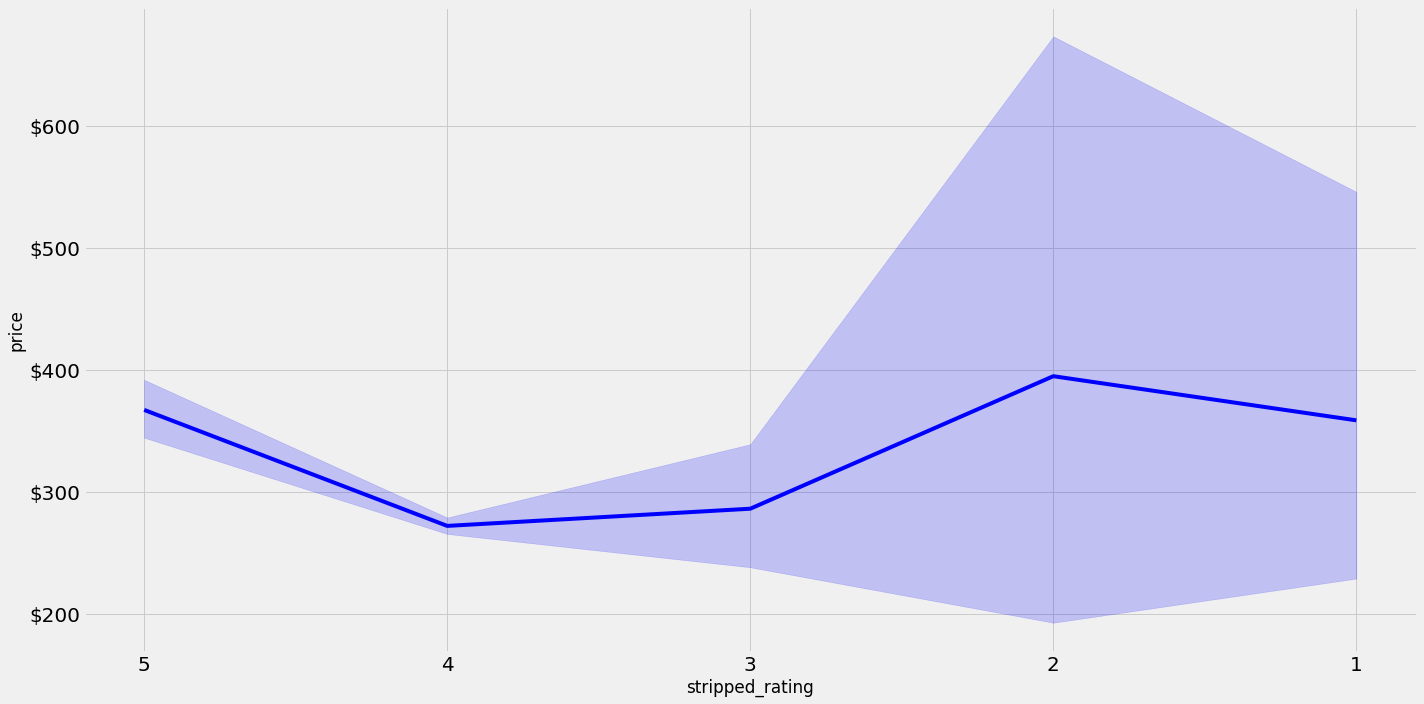

In [51]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [52]:
#new_df = df[df['5+_reviews'] == True]

In [53]:
#new_df['5+_reviews'].value_counts()

In [54]:
scatter_df = df[df['review_scores_rating'] >= 4.0]

In [55]:
scatter_mean = scatter_df['price'].mean()
scatter_mean

294.45981924767955

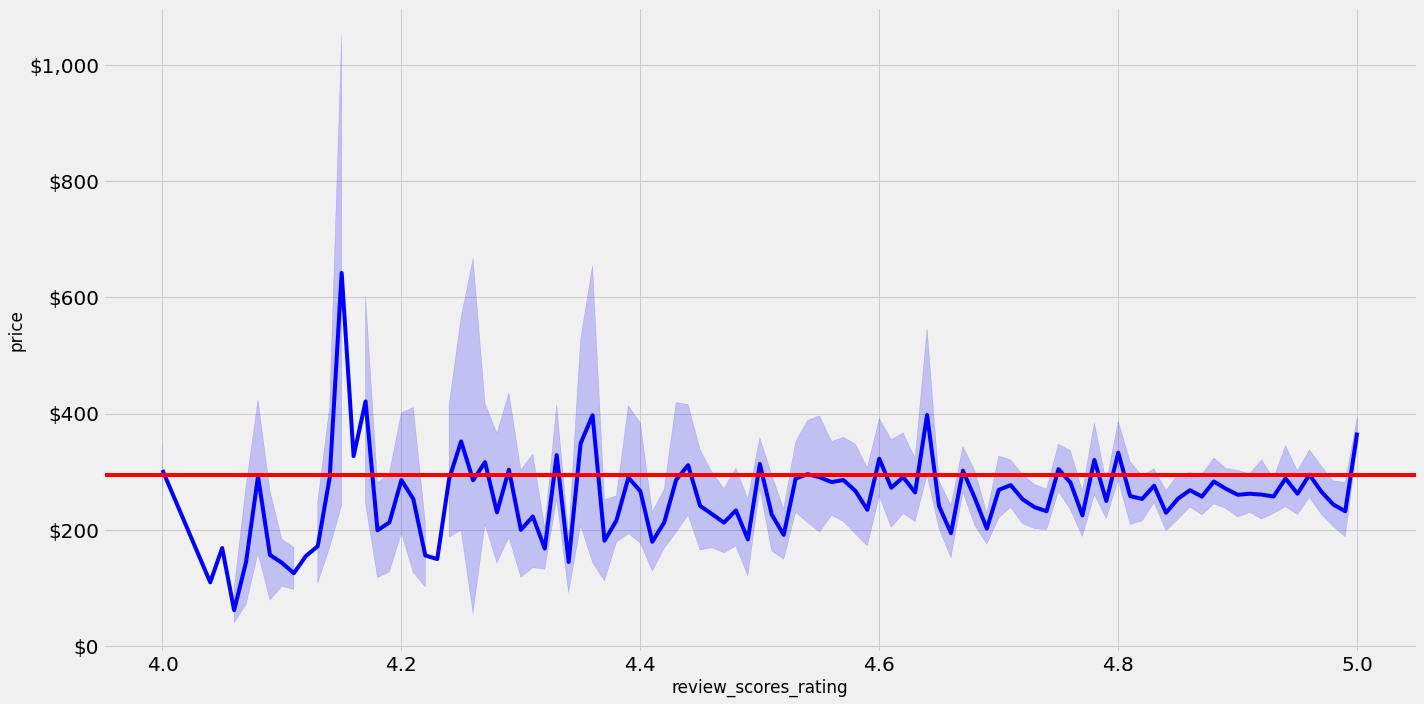

In [56]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [57]:
df.head(1)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,booked,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,2,1.0,...,True,True,True,True,True,False,True,False,True,5


In [58]:
df.sort_values('rating_5', ascending=False).head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,booked,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.0,5.00,5.00,4.0,5.00,2,1.0,...,True,True,True,True,True,False,True,False,True,5
740,1185.0,5.0,5.0,5.0,4.40,3.80,5.0,5.00,12,3.0,...,False,True,True,True,False,True,True,True,False,5
9722,379.0,5.0,5.0,5.0,5.00,5.00,5.0,5.00,8,3.0,...,False,True,True,True,True,True,True,True,False,5
9718,55.0,5.0,5.0,4.0,5.00,5.00,4.0,4.00,1,1.0,...,False,True,True,False,True,False,False,False,True,5
4819,519.0,5.0,5.0,5.0,4.93,4.93,4.6,4.97,7,4.0,...,False,True,True,True,False,False,False,True,False,5


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8385 entries, 0 to 9846
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        8385 non-null   float64
 1   review_scores_rating         8385 non-null   float64
 2   review_scores_accuracy       8385 non-null   float64
 3   review_scores_cleanliness    8385 non-null   float64
 4   review_scores_checkin        8385 non-null   float64
 5   review_scores_communication  8385 non-null   float64
 6   review_scores_location       8385 non-null   float64
 7   review_scores_value          8385 non-null   float64
 8   accommodates                 8385 non-null   int64  
 9   bedrooms                     8385 non-null   float64
 10  beds                         8385 non-null   float64
 11  instant_bookable             8385 non-null   object 
 12  property_type                8385 non-null   object 
 13  room_type         

## Modelling

### Getting Data Ready for Modelling

In [149]:
cont_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
feature_df = df.loc[:, cont_features]
feature_df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds
0,60.0,5.0,5.0,5.00,5.0,5.0,4.00,5.00,2,1.0,1.0
1900,500.0,5.0,5.0,4.91,5.0,5.0,5.00,4.73,6,3.0,3.0
1886,386.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,5,2.0,3.0
8315,152.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,2,1.0,2.0
8311,552.0,5.0,5.0,5.00,5.0,5.0,4.83,4.83,6,3.0,3.0


In [61]:
#test_df = df.drop(cont_features, axis=1)

In [62]:
#test_df

In [63]:
#feature_df.drop(['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness',
#                 'review_scores_checkin', 'review_scores_communication','review_scores_value',
#                 'review_scores_location', 'accommodates', 'bedrooms',
#                 'beds'], axis=1, inplace=True#)

In [64]:
#feature_df.drop(['review_scores_location'], axis=1, inplace=True)

In [65]:
feature_df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds
0,60.0,5.0,5.0,5.00,5.0,5.0,4.00,5.00,2,1.0,1.0
1900,500.0,5.0,5.0,4.91,5.0,5.0,5.00,4.73,6,3.0,3.0
1886,386.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,5,2.0,3.0
8315,152.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,2,1.0,2.0
8311,552.0,5.0,5.0,5.00,5.0,5.0,4.83,4.83,6,3.0,3.0


In [66]:
df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,booked,rating_5,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,price_high,price_low,stripped_rating
0,60.0,5.0,5.0,5.00,5.0,5.0,4.00,5.00,2,1.0,...,True,True,True,True,True,False,True,False,True,5
1900,500.0,5.0,5.0,4.91,5.0,5.0,5.00,4.73,6,3.0,...,True,True,True,False,True,True,False,True,False,5
1886,386.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,5,2.0,...,True,True,True,True,True,True,True,True,False,5
8315,152.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,2,1.0,...,True,True,True,True,True,True,True,False,False,5
8311,552.0,5.0,5.0,5.00,5.0,5.0,4.83,4.83,6,3.0,...,True,True,True,True,True,False,False,True,False,5


#### One Hot Encoding

In [67]:
need_to_encode = df[['rating_5', 'accuracy_5', 'cleanliness_5', 'checkin_5', 
                    'location_5', 'value_5', 'price_high', 'price_low',
                    #'capacity_1-4', 'capacity_5+',
                     'capacity_-2','capacity_-4', 'capacity_-6', 'capacity_-10', 'capacity_11+',
                    #'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+', 'instant_bookable']]
                     'bedrooms_1-2', 'bedrooms_3+', 'instant_bookable', 'booked']]
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,rating_5_False,rating_5_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,location_5_True,...,capacity_-10_True,capacity_11+_False,capacity_11+_True,bedrooms_1-2_False,bedrooms_3+_False,bedrooms_3+_True,instant_bookable_f,instant_bookable_t,booked_False,booked_True
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [68]:
# Combining everything together
#cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
#cleaned_df.head(2)

In [69]:
cleaned_df = ohe_df

In [70]:
top_rated = cleaned_df[cleaned_df['rating_5_True'] == 1]

In [71]:
low_rated = cleaned_df[cleaned_df['rating_5_False'] == 1]

#### Dropping One Value for Categoricals

In [72]:
cleaned_df = cleaned_df.drop(['rating_5_False', 'accuracy_5_False',
                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
                             'value_5_False', 'price_high_False', 'price_low_False',
                           # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
                             'bedrooms_1-2_False', 'bedrooms_3+_False',
                            #'capacity_1-4_False', 'capacity_5+_False',
                              'capacity_-2_False','capacity_-4_False', 'capacity_-6_False',
                              'capacity_-10_False', 'capacity_11+_False',
                              'instant_bookable_f', 'booked_False'],
                              axis=1)

In [73]:
#top_rated_df = top_rated.drop(['rating_5_False', 'accuracy_5_False',
#                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
#                             'value_5_False', 'price_high_False', 'price_low_False',
 #                          # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
  #                           'bedrooms_1-2_False', 'bedrooms_3+_False',
   #                         'capacity_1-4_False', 'capacity_5+_False', 'instant_bookable_f', 'booked_False'],
    #                          axis=1)

In [74]:
#low_rated_df = low_rated.drop(['rating_5_False', 'accuracy_5_False',
 #                            'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
  #                           'value_5_False', 'price_high_False', 'price_low_False',
   #                        # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
    #                         'bedrooms_1-2_False', 'bedrooms_3+_False',
     #                       'capacity_1-4_False', 'capacity_5+_False', 'instant_bookable_f', 'booked_False'],
      #                        axis=1)

In [75]:
#Dropping a few of the redundant values.
#cleaned_df= cleaned_df.drop(['rating_5_False', 'accuracy_5_False',
#                             'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
 #                            'value_5_False', 'price_high_False', 'price_low_False',
  #                         # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
   #                          'bedrooms_1-2_False', 'bedrooms_3+_False',
    #                        'capacity_1-4_False', 'capacity_5+_False', 'instant_bookable_f'], axis=1)

In [76]:
#cleaned_df= cleaned_df.drop(['price_low_True', 'price_high_True'], axis=1)
#cleaned_df= cleaned_df.drop(['price'], axis=1)

In [77]:
#cleaned_df.head(1)

#### Dealing with Class Imbalance
- Always use class weight parameter in Decision Tree Classifier
- Always stratify Train Test Split.
- Add SMOTE to Training Sets.

In [78]:
cleaned_df['rating_5_True'].value_counts()

0.0    6491
1.0    1894
Name: rating_5_True, dtype: int64

In [79]:
cleaned_df['rating_5_True']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8380    0.0
8381    0.0
8382    0.0
8383    0.0
8384    0.0
Name: rating_5_True, Length: 8385, dtype: float64

In [80]:
cleaned_df.isna().sum()

rating_5_True         0
accuracy_5_True       0
cleanliness_5_True    0
checkin_5_True        0
location_5_True       0
value_5_True          0
price_high_True       0
price_low_True        0
capacity_-2_True      0
capacity_-4_True      0
capacity_-6_True      0
capacity_-10_True     0
capacity_11+_True     0
bedrooms_3+_True      0
instant_bookable_t    0
booked_True           0
dtype: int64

In [81]:
cleaned_df = cleaned_df.dropna()
#top_rated_df = top_rated_df.dropna()
#low_rated_df = low_rated_df.dropna()

In [82]:
#top_rated_df.isna().sum()

In [83]:
#cleaned_df.info()

In [84]:
#cleaned_df.isna().sum()

In [85]:
#cleaned_df.drop(['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price'], axis=1, inplace=True)

In [86]:
#dropping accuracy to see what the feature importances are
#cleaned_df.drop(['accuracy_5_True'], axis=1, inplace=True)

In [87]:
#dropping rating_5 and searching for accuracy as the target
#cleaned_df.drop(['rating_5_True'], axis=1, inplace=True)
#top_rated_df.drop(['rating_5_True'], axis=1, inplace=True)
#low_rated_df.drop(['rating_5_True'], axis=1, inplace=True)

In [88]:
# dropping price_high as it is redundant
# price_low means that the listing is below the mean avg price
#cleaned_df.drop(['price_high_True'], axis=1, inplace=True)
#top_rated_df.drop(['price_high_True'], axis=1, inplace=True)
#low_rated_df.drop(['price_high_True'], axis=1, inplace=True)

In [89]:
booked_df = cleaned_df[cleaned_df['booked_True'] == 1]
booked_df.head()

,rating_5_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,price_high_True,price_low_True,capacity_-2_True,capacity_-4_True,capacity_-6_True,capacity_-10_True,capacity_11+_True,bedrooms_3+_True,instant_bookable_t,booked_True
0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


In [90]:
booked_df.mean()

rating_5_True         0.239490
accuracy_5_True       0.275924
cleanliness_5_True    0.241529
checkin_5_True        0.379363
location_5_True       0.318471
value_5_True          0.171975
price_high_True       0.197452
price_low_True        0.298089
capacity_-2_True      0.298599
capacity_-4_True      0.586242
capacity_-6_True      0.808917
capacity_-10_True     0.955669
capacity_11+_True     0.044331
bedrooms_3+_True      0.231592
instant_bookable_t    0.389809
booked_True           1.000000
dtype: float64

In [91]:
#cleaned_df.head(1)

In [92]:
#top_rated_df.describe()

In [93]:
#new_df = top_rated_df[['checkin_5_True', 'location_5_True', 'price_low_True', 'capacity_5+_True',
#                    'instant_bookable_t', 'booked_True']]

In [94]:
balanced_df = cleaned_df.copy()
#balanced_df = top_rated_df.copy()
#balanced_df = new_df.copy()

X = balanced_df.drop(['rating_5_True'], axis=1)
y = balanced_df['rating_5_True']
#X = balanced_df.drop(['booked_True'], axis=1)
#y = balanced_df['booked_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

### Metrics Function

In [133]:
def get_metrics(clf, y_pred):
    
    
    #clf_acc = accuracy_score(y_test, y_pred) * 100
    #print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    clf_rcl = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    clf_cv_score = np.mean(cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10))
    print('Cross Validation Score is :{0}'.format(round(clf_cv_score, 3)))

### Choosing Evaluation Metrics
- My goal is to predict whether a person will get a perfect 5.0 Airbnb rating.
- Which is worse?
    - Model predicts that someone has a perfect rating, but they actually don't? (more false Positives)
    - Model predicts that someone does not have a perfect rating, but they actually do? (more false negatives)

- I want false Positives to be as low as possible.
- If my model says that a property will have a 5.0 score, I want it to be a near guarantee.
- If it misses some that will still get a 5.0 score that is fine.
- <b>Therefore, I am most concerned with Precision, balanced out by F1 score.</b>

## Baseline Decision Tree

In [134]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)
get_metrics(dt1, dt1_y_pred)

Precision is :77.29357798165137
Recall is :71.09704641350211
F1 Score is :74.06593406593407
ROC AUC is :0.82
Cross Validation Score is :0.906


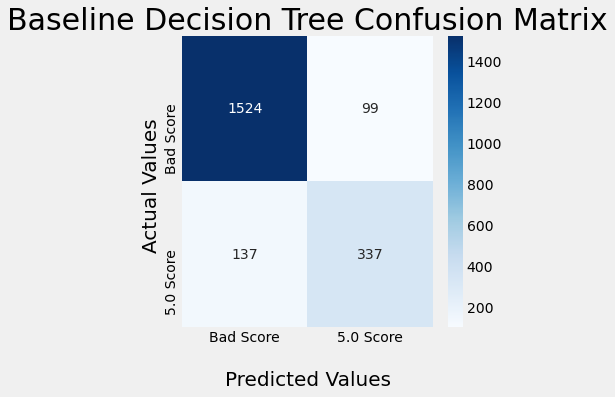

In [135]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [99]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [119]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=10, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

## Decision Tree 2

In [136]:
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)
get_metrics(dt2, dt2_y_pred)

Precision is :77.29357798165137
Recall is :71.09704641350211
F1 Score is :74.06593406593407
ROC AUC is :0.82
Cross Validation Score is :0.906


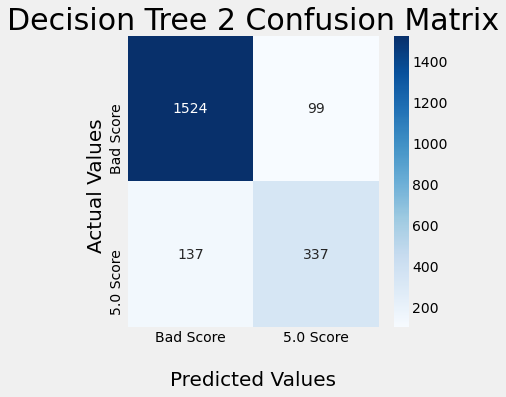

In [121]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [137]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)
get_metrics(rf1_clf, rf1_y_pred)

Precision is :74.89270386266095
Recall is :73.62869198312237
F1 Score is :74.25531914893617
ROC AUC is :0.83
Cross Validation Score is :0.914


### GridSearch CV

In [107]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [123]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'precision', cv=10)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 30}


## Random Forests 2

In [138]:
rf2_clf = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 3,
                                min_samples_split= 10, n_estimators= 30, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)
get_metrics(rf2_clf, rf2_y_pred)

Precision is :73.48066298342542
Recall is :84.17721518987342
F1 Score is :78.4660766961652
ROC AUC is :0.88
Cross Validation Score is :0.911


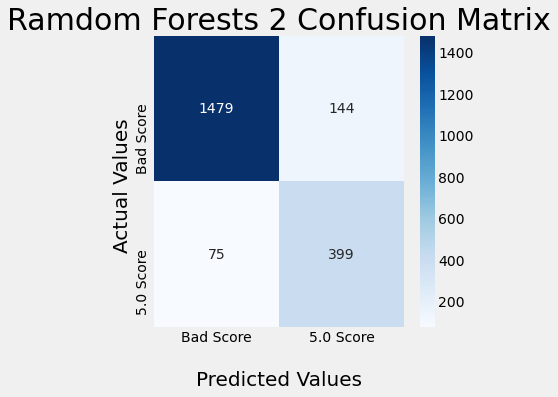

In [125]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## XGBoost Model

In [139]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)
get_metrics(xg1, xg1_y_pred)

Precision is :79.20353982300885
Recall is :75.52742616033755
F1 Score is :77.32181425485962
ROC AUC is :0.85
Cross Validation Score is :0.923


### GridSearch

In [127]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

## XGBoost 2

In [129]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='precision', cv=10, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [140]:
xg2 = XGBClassifier(learning_rate= 0.2, max_depth=6, min_child_weight=1,
                                n_estimators=100, subsample=0.7, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)
get_metrics(xg2, xg2_y_pred)

Precision is :79.41834451901566
Recall is :74.89451476793249
F1 Score is :77.0901194353963
ROC AUC is :0.85
Cross Validation Score is :0.923


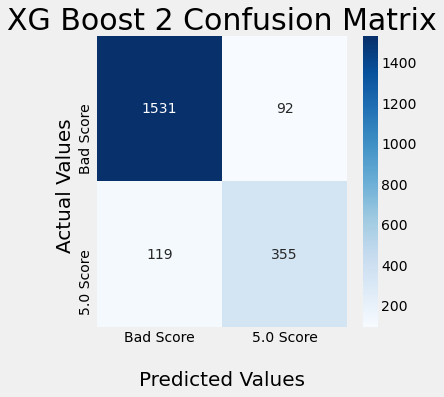

In [131]:
xg2_matrix = confusion_matrix(y_test, xg2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## FINAL MODEL = XG Boost 2

In [141]:
get_metrics(xg2, xg2_y_pred)

Precision is :79.41834451901566
Recall is :74.89451476793249
F1 Score is :77.0901194353963
ROC AUC is :0.85
Cross Validation Score is :0.923


### Model Evaluation:
- <b> Precision: </b> This Model correctly picks whether a rental will receive a perfect 5 star overall AirBnb rating 79.4% of the time.
    - This is 30% better than random guessing.
    - The Final Model is also a slight improvement over the baseline model. (about 2% better)
- <b> Recall and F1 Score: </b> The Final Model's recall and F1 Scores are also slightly higher than the baseline model. The F1 Score indicates that the Precision is balanced well with Recall.
- <b> ROC AUC Score: </b> Shows the True Positive Rate vs. the False Postive Rate. My Random Forests 2 Model performed better on this metric, but also captured more false positives. I want to avoid false positives if at all possible, so I chose XG Boost 2 over Random Forests 2.
- <b> Cross Validation Score: </b> The high score shows that this model does a good job with new data that it was not trained on.


## Feature Importance

In [142]:
feature_names = list(X)
feature_names

['accuracy_5_True',
 'cleanliness_5_True',
 'checkin_5_True',
 'location_5_True',
 'value_5_True',
 'price_high_True',
 'price_low_True',
 'capacity_-2_True',
 'capacity_-4_True',
 'capacity_-6_True',
 'capacity_-10_True',
 'capacity_11+_True',
 'bedrooms_3+_True',
 'instant_bookable_t',
 'booked_True']

In [143]:
xg2_importance = xg2.feature_importances_
xg2_importance

array([0.46229294, 0.06500179, 0.11523455, 0.0463579 , 0.07071385,
       0.02821573, 0.02952158, 0.02764697, 0.02499258, 0.0210904 ,
       0.02002536, 0.        , 0.02651325, 0.03424493, 0.02814816],
      dtype=float32)

In [144]:
#feature_importance_df = pd.DataFrame(dt2_importance, feature_names)
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,accuracy_5_True,0.462293
2,checkin_5_True,0.115235
4,value_5_True,0.070714
1,cleanliness_5_True,0.065002
3,location_5_True,0.046358
13,instant_bookable_t,0.034245
6,price_low_True,0.029522
5,price_high_True,0.028216
14,booked_True,0.028148
7,capacity_-2_True,0.027647


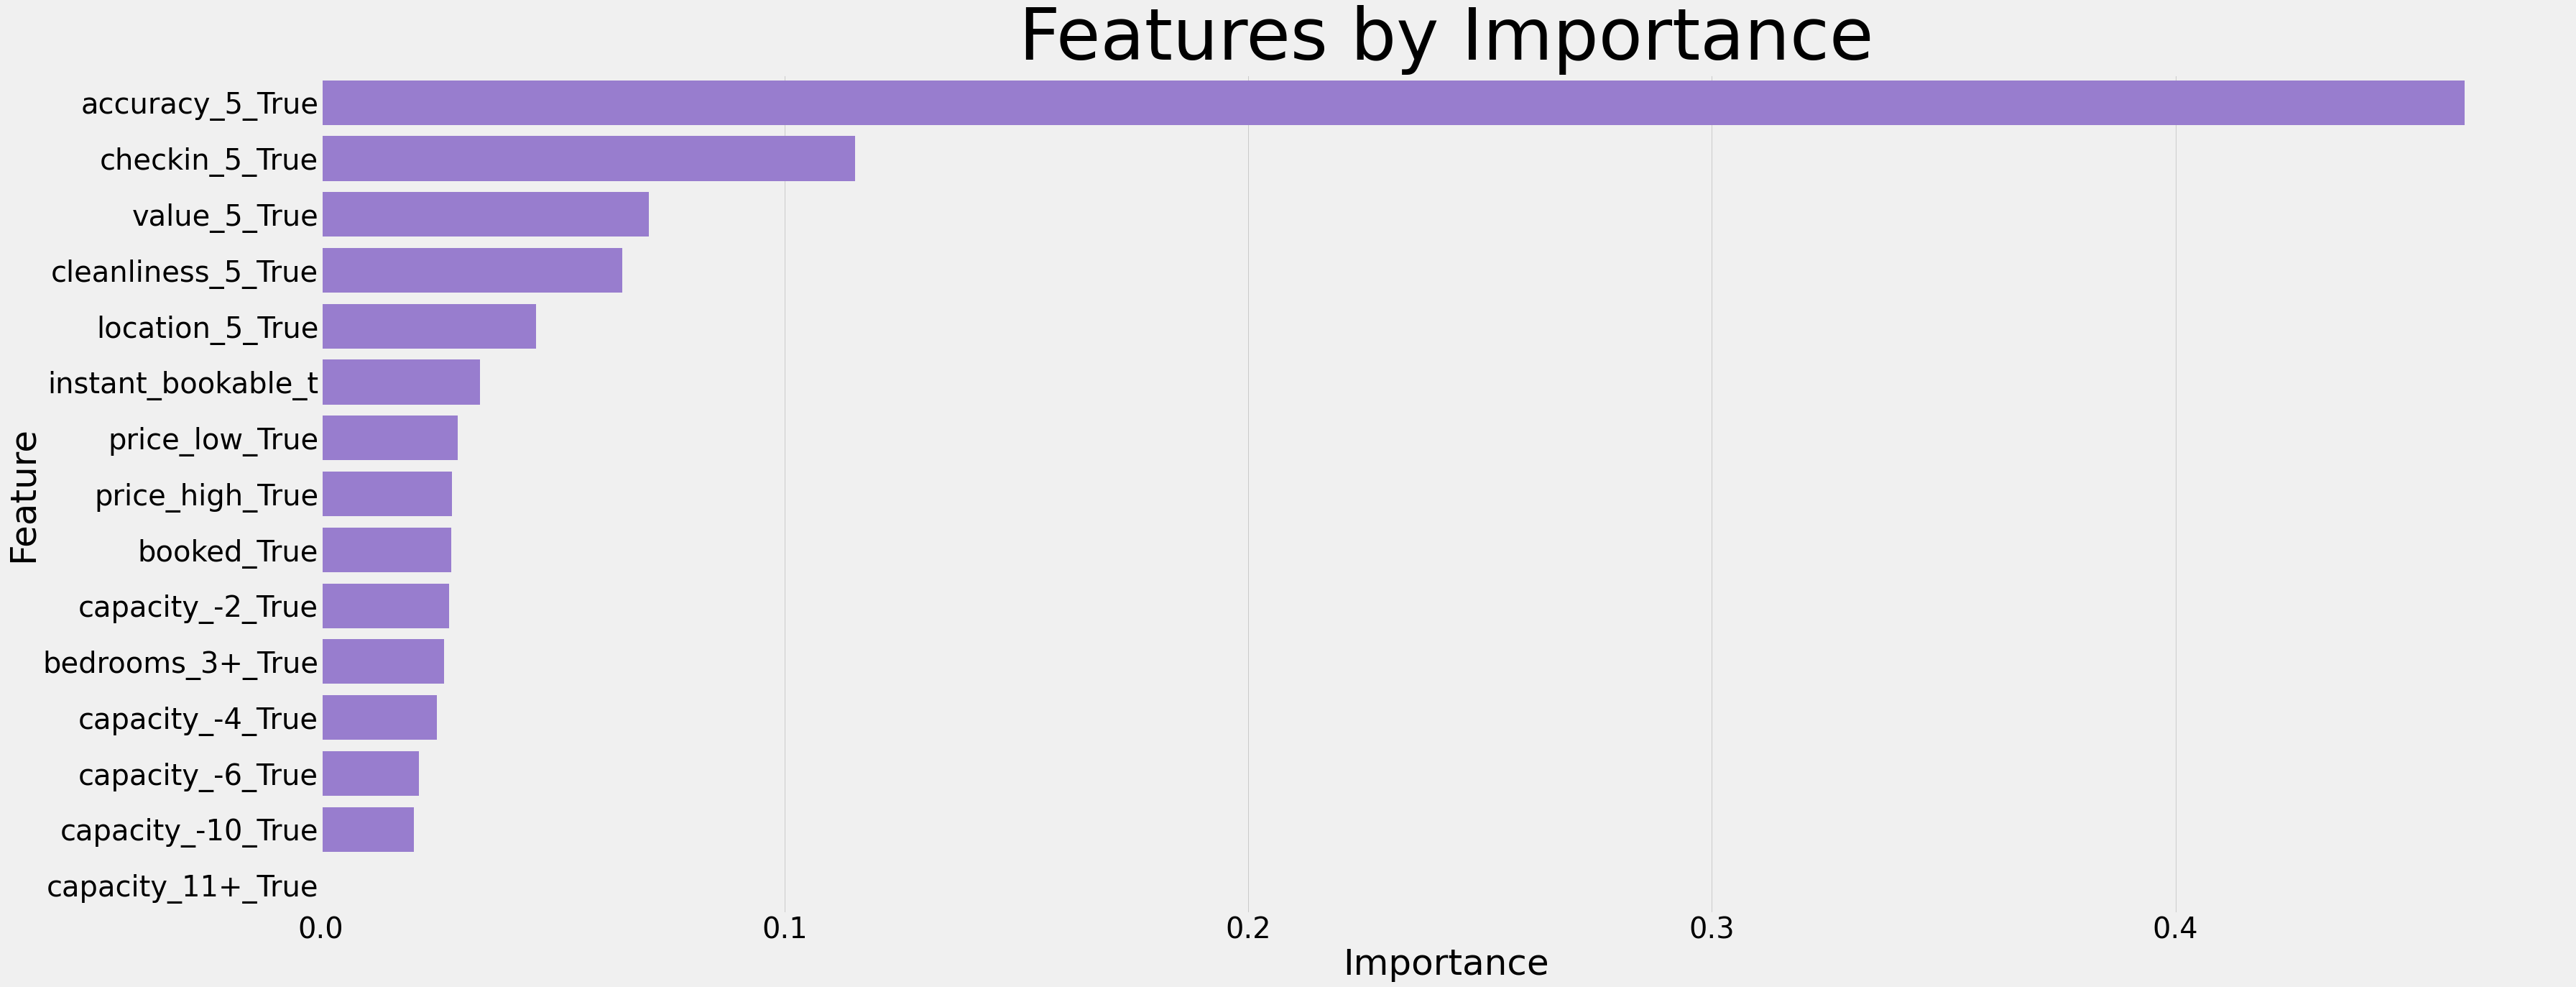

In [145]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,20))
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumpurple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

## Analysis of Features

In [151]:
feature_df.head()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,beds
0,60.0,5.0,5.0,5.00,5.0,5.0,4.00,5.00,2,1.0,1.0
1900,500.0,5.0,5.0,4.91,5.0,5.0,5.00,4.73,6,3.0,3.0
1886,386.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,5,2.0,3.0
8315,152.0,5.0,5.0,5.00,5.0,5.0,5.00,5.00,2,1.0,2.0
8311,552.0,5.0,5.0,5.00,5.0,5.0,4.83,4.83,6,3.0,3.0


In [152]:
feature_df['review_scores_rating'].value_counts()

5.00    1894
4.91     225
4.80     224
4.86     219
4.88     212
4.89     204
4.83     202
4.92     191
4.67     189
4.96     185
4.90     185
4.93     182
4.94     181
4.50     176
4.75     170
4.95     168
4.85     159
4.00     153
4.97     152
4.87     150
4.82     142
4.84     136
4.78     125
4.98     125
4.79     124
4.81     124
4.71      97
4.76      94
4.73      92
4.70      88
4.74      82
4.77      81
4.60      80
4.72      75
4.69      66
4.63      66
4.64      60
4.68      57
4.65      54
4.33      52
4.99      50
4.58      45
3.00      44
4.57      43
4.66      41
4.40      40
4.62      40
4.53      39
4.61      39
4.56      37
4.59      37
4.52      32
4.43      31
1.00      30
4.44      28
4.54      26
4.55      25
4.25      25
4.47      25
4.38      23
3.67      22
4.42      21
4.48      19
4.51      18
4.20      18
4.46      18
4.39      16
4.29      16
4.32      16
3.50      15
4.45      15
4.41      12
4.17      11
4.35      10
2.00      10
4.14      10
4.13       9

In [172]:
top_accuracy_df = feature_df[feature_df['review_scores_accuracy'] >= 3.5]
top_accuracy_df = top_accuracy_df[top_accuracy_df['review_scores_rating'] >= 3.5]

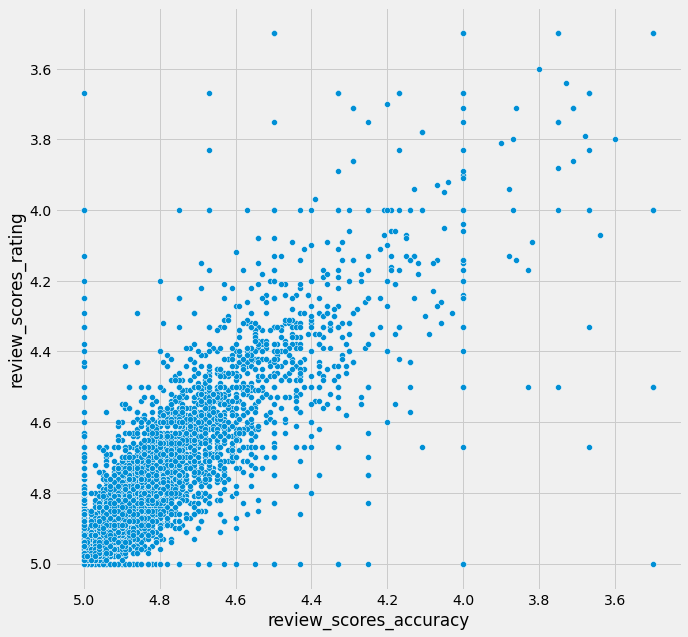

In [173]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="review_scores_accuracy", y="review_scores_rating", data=top_accuracy_df);

p.invert_xaxis()
p.invert_yaxis()


#p.set_xlabel("Total Charge: Mean Value", fontsize = 15)
#p.set_ylabel("Churn Rate", fontsize = 15)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
#p.xaxis.set_major_formatter(display_millions)
#ax.xaxis.set_major_formatter('${x:1.2f}')

#p.set_title("Churn Rate by Total Charge", fontsize = 20)
plt.figsize=(30,20) 

#line_1 = plt.axhline(y=.145, color='firebrick')
#line_2 = plt.axhline(y=0, color='black')
#line_3 = plt.axvline(x=59.45, linestyle='--',color='mediumseagreen')
#line_4 = plt.axvline(x=74.00, color='skyblue')

#ax.legend([line_1, line_3], ['Regular Churn Line', 'Mean Bill Charge'])
#plt.savefig('images/project_3_total_charge_churn')


plt.show();

### Analysis:
    - Even a small drop in accuracy results in a drop in the review score rating.

## Comparison: Location

In [174]:
top_location_df = feature_df[feature_df['review_scores_accuracy'] >= 3.5]
top_location_df = top_location_df[top_location_df['review_scores_rating'] >= 3.5]

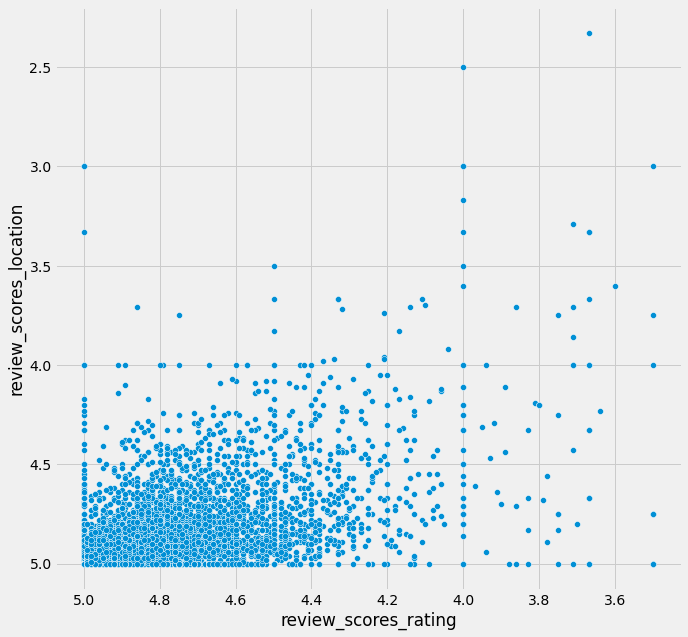

In [178]:
fig, ax = plt.subplots(figsize=(10,10))
p = sns.scatterplot(x="review_scores_rating", y="review_scores_location", data=top_location_df);

p.invert_xaxis()
p.invert_yaxis()

plt.figsize=(30,20) 

plt.show();

Analysis: Location has a much less linear relationship.

In [180]:
perfect_score_df = feature_df[feature_df['review_scores_rating'] == 5.0]

In [183]:
perfect_score_df.mean()

price                          367.488912
review_scores_rating             5.000000
review_scores_accuracy           4.956510
review_scores_cleanliness        4.921209
review_scores_checkin            4.957207
review_scores_communication      4.965602
review_scores_location           4.941816
review_scores_value              4.879245
accommodates                     5.064414
bedrooms                         2.084477
beds                             2.828933
dtype: float64

In [184]:
not_perfect_score_df = feature_df[feature_df['review_scores_rating'] < 5.0]

In [185]:
not_perfect_score_df.mean()

price                          273.624711
review_scores_rating             4.689749
review_scores_accuracy           4.751892
review_scores_cleanliness        4.708829
review_scores_checkin            4.839587
review_scores_communication      4.819276
review_scores_location           4.812223
review_scores_value              4.643340
accommodates                     5.078108
bedrooms                         1.924819
beds                             2.770143
dtype: float64

In [186]:
not_perfect_mean = not_perfect_score_df.mean()
perfect_mean = perfect_score_df.mean()